In [5]:
import warnings
warnings.filterwarnings('ignore')
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


In [6]:
# Collect all CSV files from the dataset folder
csv_files = glob.glob('CIC-IDS-2017/*.csv')

# Load and concatenate all CSVs into a single DataFrame
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Strip whitespace from column names
df_all.columns = df_all.columns.str.strip()

# Drop duplicates and missing values
df = df_all.drop_duplicates().dropna()

print('Original dataset shape:', df_all.shape)
print('Cleaned dataset shape:', df.shape)

# Ensure 'Label' column exists
if 'Label' not in df.columns:
    raise KeyError(f"'Label' column not found. Available columns: {df.columns.tolist()}")

# Display distribution of attack labels
display(df['Label'].value_counts())

Original dataset shape: (2830743, 79)
Cleaned dataset shape: (2522009, 79)


Label
BENIGN                        2096134
DoS Hulk                       172846
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [4]:
# 5. 标签编码
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])

# 6. 提取所有数值型特征（排除标签列）
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_cols if col != 'LabelEncoded']

# 7. 清洗数值列中的 inf 和 nan，并同步标签
X_raw = df[features].replace([np.inf, -np.inf], np.nan).dropna()
y = df.loc[X_raw.index, 'LabelEncoded']
X = X_raw.copy()

# 8. 用 RandomForest 拟合并评估特征重要性
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 9. 输出前15个最重要特征
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 Most Important Features:")
print(importances.head(15))


Top 15 Most Important Features:
Packet Length Std              0.060541
Packet Length Variance         0.059313
Avg Bwd Segment Size           0.058892
Max Packet Length              0.048537
Bwd Packet Length Std          0.043018
Bwd Packet Length Max          0.041547
Average Packet Size            0.040461
Subflow Fwd Bytes              0.039633
Total Length of Bwd Packets    0.034331
Total Length of Fwd Packets    0.032198
Subflow Bwd Bytes              0.031305
Bwd Packet Length Mean         0.023155
Fwd Packet Length Max          0.022424
Packet Length Mean             0.020651
Destination Port               0.020425
dtype: float64


Explained Variance Ratio:
  PC1: 0.647011
  PC2: 0.220603

Feature Contribution to Principal Components:
                                  PC1       PC2
Packet Length Std            0.388781 -0.005235
Packet Length Variance       0.360361 -0.017899
Avg Bwd Segment Size         0.375683 -0.028185
Max Packet Length            0.384503  0.007191
Bwd Packet Length Std        0.381819 -0.037562
Bwd Packet Length Max        0.383003 -0.026695
Average Packet Size          0.368996  0.011010
Subflow Fwd Bytes            0.025120  0.652227
Total Length of Bwd Packets  0.010637  0.381929
Total Length of Fwd Packets  0.025097  0.652144


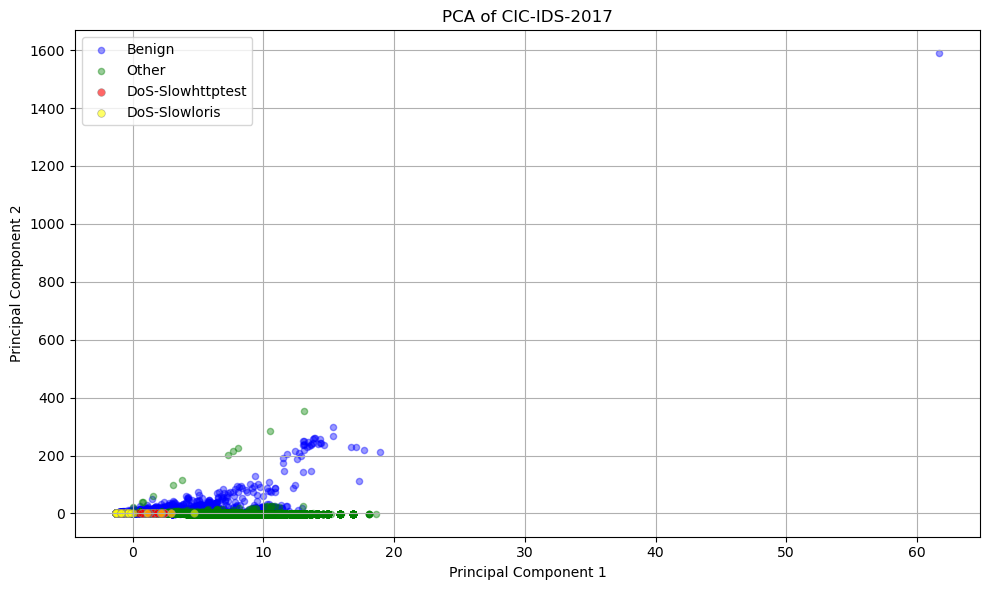

In [7]:
# 1. 选择前10个重要特征
top10_features = [
    "Packet Length Std", "Packet Length Variance", "Avg Bwd Segment Size", 
    "Max Packet Length", "Bwd Packet Length Std", "Bwd Packet Length Max", 
    "Average Packet Size", "Subflow Fwd Bytes", "Total Length of Bwd Packets", 
    "Total Length of Fwd Packets"
]

# 2. 提取特征和标签（与之前一致）
X = df[top10_features].replace([np.inf, -np.inf], np.nan).dropna()
y = df.loc[X.index, "Label"]

# 3. 归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 5. 打印解释方差比
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
for i, var in enumerate(explained_variance):
    print(f"  PC{i+1}: {var:.6f}")

# 6. 打印特征贡献（loading matrix）
loadings = pd.DataFrame(pca.components_.T, columns=["PC1", "PC2"], index=top10_features)
print("\nFeature Contribution to Principal Components:")
print(loadings)

# 7. 重新映射标签（可选：更聚焦 DoS）
def label_group(label):
    if label == "BENIGN":
        return "Benign"
    elif label == "DoS slowloris":
        return "DoS-Slowloris"
    elif label == "DoS Slowhttptest":
        return "DoS-Slowhttptest"
    else:
        return "Other"

y_grouped = y.apply(label_group)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Category"] = y_grouped.values

# 8. 绘图

# 显示类别设置（颜色+绘制顺序）
category_order = ["Benign", "Other", "DoS-Slowloris", "DoS-Slowhttptest"]
color_map = {
    "Benign": "blue",
    "Other": "green",
    "DoS-Slowloris": "yellow",
    "DoS-Slowhttptest": "red"
}

# PCA绘图
plt.figure(figsize=(10, 6))

# 先绘制容易被覆盖的类别（Benign, Other）
for cat in ["Benign", "Other"]:
    subset = pca_df[pca_df["Category"] == cat]
    plt.scatter(
        subset["PC1"], subset["PC2"],
        label=cat,
        alpha=0.4,
        s=20,
        c=color_map[cat]
    )

# 后绘制 DoS-Slowloris 与 Slowhttptest，以免被遮挡
for cat in ["DoS-Slowhttptest", "DoS-Slowloris"]:
    subset = pca_df[pca_df["Category"] == cat]
    plt.scatter(
        subset["PC1"], subset["PC2"],
        label=cat,
        alpha=0.6,
        s=30,
        c=color_map[cat],
        edgecolors='grey',
        linewidths=0.5
    )

# 图形细节
plt.title("PCA of CIC-IDS-2017")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PCA_CICIDS2017_DoSVariants.png", dpi=300)
plt.show()

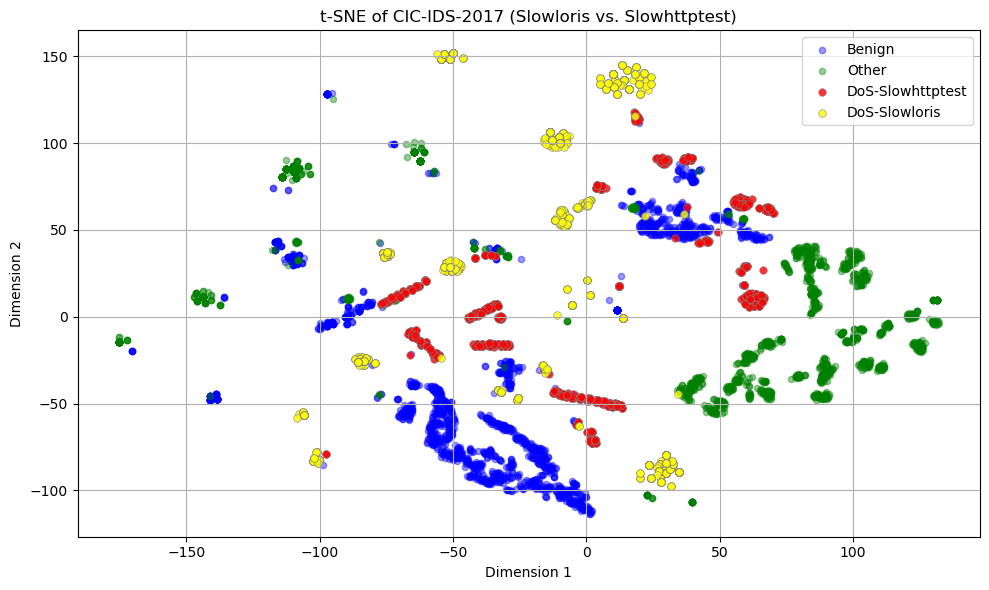

In [11]:
# 1. 选用与PCA一致的前10重要特征
top10_features = [
    "Packet Length Std", "Packet Length Variance", "Avg Bwd Segment Size", 
    "Max Packet Length", "Bwd Packet Length Std", "Bwd Packet Length Max", 
    "Average Packet Size", "Subflow Fwd Bytes", "Total Length of Bwd Packets", 
    "Total Length of Fwd Packets"
]

# 2. 清洗 & 标准化
X = df[top10_features].replace([np.inf, -np.inf], np.nan).dropna()
y = df.loc[X.index, "Label"]

# 3. 简单标签映射（与PCA一致）
def label_group(label):
    if label == "BENIGN":
        return "Benign"
    elif label == "DoS slowloris":
        return "DoS-Slowloris"
    elif label == "DoS Slowhttptest":
        return "DoS-Slowhttptest"
    else:
        return "Other"

y_grouped = y.apply(label_group)

# 4. 重新采样，每类最多 2000 样本
df_sampled = pd.concat([
    pd.DataFrame(X).assign(Category=y_grouped).groupby("Category").apply(
        lambda g: g.sample(n=min(2000, len(g)), random_state=42)
    ).reset_index(drop=True)
])

X_sample = df_sampled[top10_features].values
y_sample = df_sampled["Category"]

# 5. 标准化 + PCA 降维预处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)
X_pca = PCA(n_components=10, random_state=42).fit_transform(X_scaled)

# 6. t-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=2000, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# 7. 构建 DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
tsne_df["Category"] = y_sample.values

# 8. 可视化参数（突出 DoS 类别）
color_map = {
    "Benign": "blue",
    "Other": "green",
    "DoS-Slowloris": "yellow",
    "DoS-Slowhttptest": "red"
}
category_order = ["Benign", "Other", "DoS-Slowloris", "DoS-Slowhttptest"]

plt.figure(figsize=(10, 6))

# 背景类（透明度低）
for cat in ["Benign", "Other"]:
    subset = tsne_df[tsne_df["Category"] == cat]
    plt.scatter(
        subset["Dim1"], subset["Dim2"],
        label=cat,
        alpha=0.4,
        s=20,
        c=color_map[cat]
    )

# 高亮 DoS 类（颜色鲜明 + 上层显示）
for cat in ["DoS-Slowhttptest", "DoS-Slowloris"]:
    subset = tsne_df[tsne_df["Category"] == cat]
    plt.scatter(
        subset["Dim1"], subset["Dim2"],
        label=cat,
        alpha=0.8,
        s=30,
        c=color_map[cat],
        edgecolors='grey',
        linewidths=0.5
    )

# 图形细节
plt.title("t-SNE of CIC-IDS-2017 (Slowloris vs. Slowhttptest)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("tSNE_CICIDS2017_DoSVariants.png", dpi=300)
plt.show()